In [1]:
import pandas as pd
from scipy.stats import norm
import statsmodels.stats.meta_analysis as meta
import numpy as np
from statsmodels.stats.multitest import multipletests
import re
import itertools as it
import os

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 6, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 5, 'ytick.major.width': 1, 'ytick.major.size': 5})
from matplotlib.backends.backend_pdf import PdfPages

# import warnings

# # Suppress all warnings
# warnings.filterwarnings('ignore')

In [2]:
aou_df = pd.read_csv("../data/meta/bmi_aou_meta_w_samples.csv.gz")
ukb_df = pd.read_csv("../data/meta/bmi_ukb_meta_w_samples.csv.gz")

In [3]:
meta_df = aou_df.merge(ukb_df, on="ID", how="outer")
meta_df = meta_df.loc[meta_df.ID.str.contains("0.001")].reset_index(drop=True)
bonf_p = 0.05/(20000*3)

In [4]:
eur_ancestry = ["british", "eur"]
neur_ancestry = ["nonbritish", "afr", "oth"]

pop_df = pd.DataFrame()

for anc in eur_ancestry+neur_ancestry:
    anc_df = meta_df.loc[(meta_df[f"p_value_{anc}"]<bonf_p)&(meta_df[f"nsamples_{anc}"]>20)]
    anc_df = anc_df.loc[:, ["ID"] + [c for c in anc_df.columns if c.endswith(f"_{anc}")]]
    anc_df.columns = [c.replace(f"_{anc}", "") for c in anc_df.columns]
    anc_df["population"] = anc
    pop_df = pd.concat((pop_df, anc_df))

In [5]:
pop_df.to_excel("../data/meta/independent_pop_assoc.xlsx", index=False)

In [6]:
def get_meta_stats_helper(ser, ancestry):
    effect_sizes = np.array([ser[f"BETA_{a}"] for a in ancestry])
    variances = np.array([(ser[f"SE_{a}"]**2)*ser[f"N_{a}"] for a in ancestry])
    summary = meta.combine_effects(effect_sizes, variances, method_re="iterated")
    summary_df = summary.summary_frame()
    combined_effect_size = summary_df.loc["random effect wls", "eff"]
    combined_se = summary_df.loc["random effect wls", "sd_eff"]
    ci_low = summary_df.loc["random effect wls", "ci_low"]
    ci_high = summary_df.loc["random effect wls", "ci_upp"]
    # Calculate the Z-score
    z_score = combined_effect_size / combined_se
    # Calculate the two-tailed p-value
    p_value = 2 * (1 - norm.cdf(abs(z_score)))
    nsamples = sum([ser[f"nsamples_{a}"] for a in ancestry])
    return combined_effect_size, combined_se, ci_low, ci_high, z_score, p_value, nsamples


def get_meta_stats(ser):
    discovery_ancestry = ["british", "eur"]
    replication_ancestry =  ["nonbritish", "afr", "oth"]
    des, dse, dci_low, dci_high, dz_score, dp_value, dsamples = get_meta_stats_helper(ser, discovery_ancestry)
    res, rse, rci_low, rci_high, rz_score, rp_value, rsamples = get_meta_stats_helper(ser, replication_ancestry)
    es, se, ci_low, ci_high, z_score, p_value, nsamples = get_meta_stats_helper(ser, discovery_ancestry+replication_ancestry)
    return pd.Series(
        {"ID": ser.ID, "beta": es, "se": se, "ci_low": ci_low, "ci_high": ci_high, "z_score":z_score, "p_value": p_value, "nsamples": nsamples,
        "dbeta": des, "dse": dse, "dci_low": dci_low, "dci_high": dci_high, "dz_score":dz_score, "dp_value": dp_value, "dsamples": dsamples,
        "rbeta": res, "rse": rse, "rci_low": rci_low, "rci_high": rci_high, "rz_score":rz_score, "rp_value": rp_value, "rsamples": rsamples,
        })

In [7]:
RERUN=False
if RERUN:
    meta_res_df = meta_df.apply(get_meta_stats, axis=1)
    bonf_p = 0.05/(20000*3)
    sig_meta_res_df = meta_res_df.loc[
        ((meta_res_df.dp_value<bonf_p)|(meta_res_df.rp_value<bonf_p))&
        (meta_res_df.p_value<bonf_p)
        ]
    sig_meta_res_df.to_excel("../data/meta/monogenic_meta.xlsx", index=False)

# Save risk and protective

In [8]:
sig_meta_res_df = pd.read_excel("../data/meta/monogenic_meta.xlsx")

# Plotting

In [9]:
plot_df = sig_meta_res_df.copy()
plot_df["gene"] = plot_df.ID.str.split(".", expand=True).iloc[:, 0]
plot_df["abs_beta"] = plot_df.beta.abs()
plot_df = plot_df.loc[plot_df.groupby('gene')['p_value'].idxmin()].sort_values("abs_beta")
plot_df = plot_df.drop(columns=["ID"])

In [10]:
risk_gene_df = plot_df.loc[(plot_df.beta>0)].sort_values("abs_beta", ascending=False).loc[:, ["gene", "beta", "p_value"]]
protective_gene_df = plot_df.loc[(plot_df.beta<0)].sort_values("abs_beta", ascending=False).loc[:, ["gene", "beta", "p_value"]]

In [11]:
risk_gene_df.to_excel("../data/meta/risk_meta.xlsx", index=False)
protective_gene_df.to_excel("../data/meta/protective_meta.xlsx", index=False)

In [12]:
def highest_effect(x):
    x=list(x)
    return x[np.argmax(np.abs(x))]

def p_value_formatter(pval):
    if pval==0:
        pval = "0"
    else:
        pval = f"{pval:.2e}"
        pval = pval.replace("e", "x10")
        # base, exponent = pval.split("^")
        # pval = f"{base}$^{{{exponent}}}$"
        # #pval = f"{base}$^{exponent}$"
    return pval

plot_columns = [c for c in plot_df.columns if c!="gene"]
plot_df = plot_df.groupby("gene").agg({k: "min" if k.endswith('p_value') else highest_effect for k in plot_columns}).sort_values("abs_beta", ascending=False)
plot_df = plot_df.loc[plot_df.beta.abs()>1.5]

meta_analysis = ["", "d", "r"]
meta_category = ["all", "european", "non-european"]
stats_cols = ["beta", "se", "ci_low", "ci_high", "z_score", "p_value"]

long_plot_df = pd.DataFrame()

for m,c in zip(meta_analysis, meta_category):
    pdf = plot_df.loc[:, [f"{m}{s}" for s in stats_cols]]
    pdf.columns = stats_cols
    pdf["category"] = c
    long_plot_df = pd.concat((long_plot_df, pdf))

long_plot_df = long_plot_df.reset_index()
long_plot_df["formatted_beta"] = long_plot_df.beta.apply(lambda x: f"{x:.2f}")
long_plot_df["formatted_ci"] = "(" + long_plot_df.ci_low.apply(lambda x: f"{x:.2f}") + ", " + long_plot_df.ci_high.apply(lambda x: f"{x:.2f}") + ")"
long_plot_df["formatted_se"] = long_plot_df.se.apply(lambda x: f"{x:.2f}")
long_plot_df["formatted_z_score"] = long_plot_df.z_score.apply(lambda x: f"{x:.2f}")
long_plot_df["formatted_p_value"] = long_plot_df.p_value.apply(p_value_formatter)


In [13]:
long_plot_df["Beta (95% CI)"] = long_plot_df.apply(lambda ser: f"{ser.formatted_beta} {ser.formatted_ci}", axis=1)

In [14]:
protective_long_plot_df = long_plot_df.loc[long_plot_df.beta<0]
risk_long_plot_df = long_plot_df.loc[long_plot_df.beta>0]

In [15]:
def create_forestplot(
    df, studies, categories, 
    labels_col, categories_col, effect_sizes_col, ci_low_col, ci_high_col,
    stats_cols
):
    # Define markers for each category
    markers = dict(it.zip_longest(categories, "osD", fillvalue="o"))
    # Define colors for each category
    palette = ["royalblue", "indianred", "gray"] # ["lightgrey", "darkgrey", "black"]

    colors = dict(it.zip_longest(categories, palette, fillvalue="black"))

    # Create a figure with two axes
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(3.5, 4.5), gridspec_kw={'width_ratios': [1, 2.5]},sharey=True)

    # Horizontal line at 0 for the null effect
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    
    df["ci_low_error"] = df[effect_sizes_col] - df[ci_low_col]
    df["ci_high_error"] =  df[ci_high_col] - df[effect_sizes_col]
    study_offset=1.25
    cat_offset=1
    ### main plot ###
    # Plotting the effect sizes with different markers per category
    for i, study in enumerate(studies):
        offset = study_offset*i
        for j, category in enumerate(categories):
            # Get the index for this category
            idx = i * len(categories) + j*cat_offset
            effect_size = df.loc[(df[labels_col]==study)&(df[categories_col]==category), effect_sizes_col].values[0]
            ci_low_error = df.loc[(df[labels_col]==study)&(df[categories_col]==category), "ci_low_error"].values[0]
            ci_high_error = df.loc[(df[labels_col]==study)&(df[categories_col]==category), "ci_high_error"].values[0]
            errors = np.array([ci_low_error, ci_high_error]).reshape(2, 1)
            # Plot each category with a different marker
            ax.errorbar(
                effect_size, idx+offset, xerr=[[ci_low_error], [ci_high_error]], fmt=markers[category], 
                color=colors[category], capsize=2, elinewidth=1, ms=4.5)

        # Place the study name above the group of categories
        ax.text(min(df[ci_low_col])-2, len(categories)*i+1+offset, study, ha='center', va='center', fontweight='normal', style="italic") # * * len(categories)
    
    ax.text(min(df[ci_low_col])-2, -2, "Genes", ha='center', va='center', fontweight='normal')
    
    # Invert the y-axis so the studies are from top to bottom
    ax.invert_yaxis()

    # Customize the left axis: remove yticks but keep the ytick labels for study names
    ax.set_yticks([])
    ax.tick_params(axis='y', which='both', length=0) 


    # Labels for axes
    ax.set_xlabel('Effect Size', fontsize=7)
    # ax.set_title('Forest Plot')
    # Remove top, right, and left spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.legend(labels=["vline"]+categories, frameon=False, loc="best", ncol=1)

    # for idx, stat in enumerate(statistics):

    for i, study in enumerate(studies):
        offset = study_offset*i
        for j, category in enumerate(categories):
            for s, st_col in enumerate(stats_cols):
                idx = i * len(categories) + j*cat_offset
                stat = df.loc[(df[labels_col]==study)&(df[categories_col]==category), st_col].values[0]
                ax2.text(0.1+0.35*s, idx+offset, f"{stat}", va='center', ha="center")
                ax2.text(0.1+0.35*s, -2, f"{st_col.lstrip('formatted_')}", va='center', ha="center")

    # Remove the spines and ticks for ax2
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    # ax2.set_title('Statistics')

    plt.tight_layout()
    return fig


In [16]:
def save_pdf(save_file, fig):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return

/var/folders/nc/7c09ww457r580z0qc6055g8m0000gn/T/ipykernel_36577/1275633995.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ci_low_error"] = df[effect_sizes_col] - df[ci_low_col]
/var/folders/nc/7c09ww457r580z0qc6055g8m0000gn/T/ipykernel_36577/1275633995.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ci_high_error"] =  df[ci_high_col] - df[effect_sizes_col]


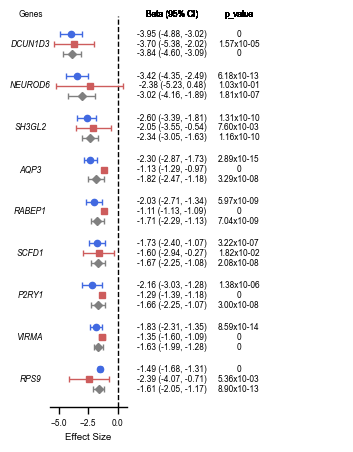

In [17]:
fig = create_forestplot(
    protective_long_plot_df, protective_long_plot_df.gene.unique(), ["non-european", "european", "all"],
    labels_col="gene", categories_col="category", effect_sizes_col="beta", ci_low_col="ci_low", ci_high_col="ci_high",
    stats_cols=["Beta (95% CI)", "formatted_p_value"]
)



In [35]:
save_pdf("../data/meta/protective_v2.pdf", fig)

/var/folders/nc/7c09ww457r580z0qc6055g8m0000gn/T/ipykernel_36577/1275633995.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ci_low_error"] = df[effect_sizes_col] - df[ci_low_col]
/var/folders/nc/7c09ww457r580z0qc6055g8m0000gn/T/ipykernel_36577/1275633995.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ci_high_error"] =  df[ci_high_col] - df[effect_sizes_col]


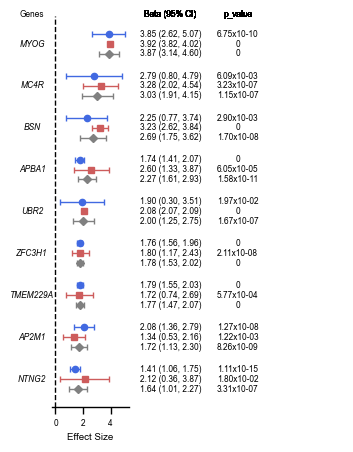

In [18]:
fig = create_forestplot(
    risk_long_plot_df, risk_long_plot_df.gene.unique(), ["non-european", "european", "all"],
    labels_col="gene", categories_col="category", effect_sizes_col="beta", ci_low_col="ci_low", ci_high_col="ci_high",
    stats_cols=["Beta (95% CI)", "formatted_p_value"]
)

In [37]:
save_pdf("../data/meta/risk_v2.pdf", fig)